# Hierarchical RAG System for Zuleika Dobson

Bu notebook, Project Gutenberg'den "Zuleika Dobson" kitabını kullanarak hiyerarşik parçalama yöntemiyle bir RAG (Retrieval-Augmented Generation) sistemi oluşturur.

**Proje Detayları:**
- **Kitap:** Zuleika Dobson by Max Beerbohm
- **Dataset:** NarrativeQA (İlgili kitap için 40 test sorusu)
- **Vector DB:** Milvus Lite tercih ettim
- **Embedding Model:** all-MiniLM-L6-v2
- **LLM:** google/gemma-3-1b-it
- **Metrikler:** BLEU, ROUGE-1, ROUGE-2, ROUGE-L

---
## 1. Kurulum ve Hazırlık

### 1.1 Kütüphaneleri Kur

In [1]:
import os


if not os.path.exists('V-RAG'):
    !git clone https://github.com/sendayildirim/V-RAG
    %cd V-RAG
else:
    %cd V-RAG
    !git pull

import sys
sys.path.append('src')

print("proje yüklendi")
!ls

/content/V-RAG
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (20/20), 26.23 KiB | 440.00 KiB/s, done.
From https://github.com/sendayildirim/V-RAG
   cecb07b..636598f  main       -> origin/main
Updating cecb07b..636598f
Fast-forward
 notebooks/main_rag_notebook.ipynb | 4380 ++++++++++++++++++++++++++++++++++++-
 src/baseline_model.py             |   29 +-
 src/rag_pipeline.py               |   41 +-
 3 files changed, 4351 insertions(+), 99 deletions(-)
proje yüklendi
data	 milvus_rag.db	README.md	  src
LICENSE  notebooks	requirements.txt  V-RAG


In [2]:
!pip install -q -r requirements.txt


### 1.2 Gerekli Modülleri İçe Aktar

In [3]:
import sys
sys.path.append('src')

from data_loader import DataLoader
from chunker import HierarchicalChunker
from vector_store import VectorStore
from rag_pipeline import RAGPipeline
from baseline_model import BaselineModel
from metrics import MetricsEvaluator
from experiment_runner import ExperimentRunner

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch

print("modüller yüklendi!")
print(f"GPU kullanılabilme durumu: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

modüller yüklendi!
GPU kullanılabilme durumu: True
GPU: Tesla T4


---
## 2. Veri Hazırlama

### 2.1 Kitap ve Soruları İndir

In [4]:
# Data loader oluştur ve verileri indir
loader = DataLoader(data_dir="data")
data_paths = loader.load_all_data()

print("\nİndirilen dosyalar:")
print(f"  book: {data_paths['book']}")
print(f"  test: {data_paths['test']}")

Kitap indiriliyor...
Kitap kaydedildi: data/zuleika_dobson.txt
Sorular indiriliyor...

Toplam 40 soru bulundu
Test: 40

Sorular kaydedildi:
  Test: data/questions_test.csv

İndirilen dosyalar:
  book: data/zuleika_dobson.txt
  test: data/questions_test.csv


### 2.2 Test Verilerini İncele

In [5]:
# Test sorularını yükle
test_df = pd.read_csv(data_paths['test'])

print(f"Toplam test sorusu: {len(test_df)}")
print("\nİlk 3 soru:")
print(test_df[['question', 'answer1', 'answer2']].head(3))

Toplam test sorusu: 40

İlk 3 soru:
                                            question  \
0          Who are Zuleika's most prominent suitors?   
1                  Why does Zuleika reject the Duke?   
2  Who is the first person Zuleika falls in love ...   

                                             answer1  \
0                       The Duke of Dorset and Noaks   
1  She claims she can only love someone who is im...   
2                                 The Duke of Dorset   

                               answer2  
0             Duke of Dorset and Noaks  
1  She felt he was too charmed by her.  
2             With the Duke of Dorset.  


---
## 3. Hiyerarşik Chunking

### 3.1 Chunker Oluştur ve Metni Parçala

In [6]:
# Kitap metnini yükle
with open(data_paths['book'], 'r', encoding='utf-8') as f:
    book_text = f.read()

print(f"Kitap uzunluğu: {len(book_text)} karakter")

# Chunker oluştur (Parent: 512, Child: 256, Overlap: 50)
chunker = HierarchicalChunker(
    parent_size=512,
    child_size=256,
    overlap=50
)

# Metni parçala
parent_chunks, child_chunks = chunker.chunk_text(book_text)

# İstatistikler
stats = chunker.get_chunk_stats(parent_chunks, child_chunks)
print("\nChunk İstatistikleri:")
for key, value in stats.items():
    print(f"  {key}: {value:.1f}" if isinstance(value, float) else f"  {key}: {value}")

Kitap uzunluğu: 467638 karakter
Toplam 245 parent chunk olusturuldu
Toplam 734 child chunk olusturuldu

Chunk İstatistikleri:
  parent_count: 245
  child_count: 734
  parent_avg_tokens: 511.1
  child_avg_tokens: 187.3
  parent_max_tokens: 512
  child_max_tokens: 256


### 3.2 Chunk Örneklerini Görüntüle

In [7]:
# Bir parent chunk ve onun child'larını göster
sample_parent = parent_chunks[0]
sample_children = [c for c in child_chunks if c['parent_id'] == sample_parent['id']]

print("Örnek Parent Chunk:")
print(f"ID: {sample_parent['id']}")
print(f"Token sayısı: {sample_parent['token_count']}")
print(f"Metin (ilk 200 karakter): {sample_parent['text'][:200]}...")

print("\nBu parent'ın child chunk'ları:")
for child in sample_children:
    print(f"  - {child['id']}: {child['token_count']} token")

Örnek Parent Chunk:
ID: parent_0
Token sayısı: 512
Metin (ilk 200 karakter): Produced by Judy Boss

ZULEIKA DOBSON

or, AN OXFORD LOVE STORY

By Max Beerbohm

 NOTE to the 1922 edition

 I was in Italy when this book was first published.
 A year later (1912) I visited London, ...

Bu parent'ın child chunk'ları:
  - child_0_0: 256 token
  - child_0_1: 256 token
  - child_0_2: 50 token


---
## 4. Vector Store ve Embedding

### 4.1 Milvus Lite Vector Store Oluştur

In [8]:
# Vector store oluştur
vector_store = VectorStore(
    db_path="./milvus_rag.db",
    model_name="all-MiniLM-L6-v2"
)

# Collection'ları oluştur
vector_store.create_collections()

print(f"Embedding boyutu: {vector_store.embedding_dim}")

Embedding modeli yukleniyor: all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Collection'lar olusturuldu: parent_chunks, child_chunks
Embedding boyutu: 384


### 4.2 Chunk'ları İndeksle

In [9]:
import time

# Parent chunk'ları ekle
start = time.time()
vector_store.insert_parent_chunks(parent_chunks)
parent_time = time.time() - start

# Child chunk'ları ekle
start = time.time()
vector_store.insert_child_chunks(child_chunks)
child_time = time.time() - start

print(f"\nParent indexing süresi: {parent_time:.2f}s")
print(f"Child indexing süresi: {child_time:.2f}s")
print(f"Toplam indexing süresi: {parent_time + child_time:.2f}s")

245 parent chunk eklendi
734 child chunk eklendi

Parent indexing süresi: 1.58s
Child indexing süresi: 1.89s
Toplam indexing süresi: 3.47s


### 4.3 Retrieval Testi

In [10]:
# Test sorusu ile retrieval dene
test_query = "Who are Zuleika's most prominent suitors?"

parent_results, child_results = vector_store.hybrid_search(
    query=test_query,
    top_parents=3,
    top_children=5
)

print(f"Test sorusu: {test_query}")
print(f"\nBulunan {len(child_results)} child chunk:")
for i, result in enumerate(child_results[:3], 1):
    print(f"\n{i}. Score: {result['score']:.4f}")
    print(f"   Metin: {result['text'][:150]}...")

Test sorusu: Who are Zuleika's most prominent suitors?

Bulunan 5 child chunk:

1. Score: 0.5889
   Metin:  or colour had
the two women in common. It has been said that Zuleika was not strictly
beautiful. Melisande, like most Frenchwomen, was strictly plain...

2. Score: 0.5479
   Metin:  here were five young men deeply under the spell of
Zuleika. They must be saved, if possible. He knew how strong his
influence was in the University. ...

3. Score: 0.5402
   Metin:  reflects.

Zuleika was not strictly beautiful. Her eyes were a trifle large, and
their lashes longer than they need have been. An anarchy of small cu...


---
## 5. Baseline Model (RAG'sız)

### 5.1 Baseline Model Oluştur

In [16]:
from huggingface_hub import login
login(new_session=False)

In [17]:
# Baseline model oluştur
baseline = BaselineModel(model_name="google/gemma-3-1b-it")

Cihaz: cuda
Baseline model yukleniyor: google/gemma-3-1b-it


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Baseline model yuklendi!


### 5.2 Baseline ile Test Sorularını Cevapla

In [18]:
# Test sorularını al
questions = test_df['question'].tolist()

# Baseline ile cevapla
print("Baseline model ile sorular cevaplanıyor...")
baseline_results = baseline.batch_answer_questions(questions, max_new_tokens=100)

print(f"\n{len(baseline_results)} soru cevaplandı!")

# İlk 3 cevabı göster
print("\nÖrnek Baseline Cevaplar:")
for i, result in enumerate(baseline_results[:3], 1):
    print(f"\n{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")

Baseline model ile sorular cevaplanıyor...

Soru 1/40 cevaplanıyor...

Soru 2/40 cevaplanıyor...

Soru 3/40 cevaplanıyor...

Soru 4/40 cevaplanıyor...

Soru 5/40 cevaplanıyor...

Soru 6/40 cevaplanıyor...

Soru 7/40 cevaplanıyor...

Soru 8/40 cevaplanıyor...

Soru 9/40 cevaplanıyor...

Soru 10/40 cevaplanıyor...

Soru 11/40 cevaplanıyor...

Soru 12/40 cevaplanıyor...

Soru 13/40 cevaplanıyor...

Soru 14/40 cevaplanıyor...

Soru 15/40 cevaplanıyor...

Soru 16/40 cevaplanıyor...

Soru 17/40 cevaplanıyor...

Soru 18/40 cevaplanıyor...

Soru 19/40 cevaplanıyor...

Soru 20/40 cevaplanıyor...

Soru 21/40 cevaplanıyor...

Soru 22/40 cevaplanıyor...

Soru 23/40 cevaplanıyor...

Soru 24/40 cevaplanıyor...

Soru 25/40 cevaplanıyor...

Soru 26/40 cevaplanıyor...

Soru 27/40 cevaplanıyor...

Soru 28/40 cevaplanıyor...

Soru 29/40 cevaplanıyor...

Soru 30/40 cevaplanıyor...

Soru 31/40 cevaplanıyor...

Soru 32/40 cevaplanıyor...

Soru 33/40 cevaplanıyor...

Soru 34/40 cevaplanıyor...

Soru 35/40 ce

---
## 6. RAG Pipeline

### 6.1 RAG Pipeline Oluştur

In [19]:
# RAG pipeline oluştur
rag_pipeline = RAGPipeline(
    vector_store=vector_store,
    model_name="google/gemma-2-2b-it",
    temperature=0.1
)

Cihaz: cuda
Model yukleniyor: google/gemma-2-2b-it


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model yuklendi!


### 6.2 RAG ile Test Sorularını Cevapla

In [20]:
# RAG ile cevapla
print("RAG pipeline ile sorular cevaplanıyor...")
rag_results = rag_pipeline.batch_answer_questions(
    questions,
    top_k_children=5,
    max_new_tokens=100
)

print(f"\n{len(rag_results)} soru cevaplandı!")

# İlk 3 cevabı göster
print("\nÖrnek RAG Cevaplar:")
for i, result in enumerate(rag_results[:3], 1):
    print(f"\n{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")
    print(f"   Context (ilk 100 karakter): {result['context'][:100]}...")

RAG pipeline ile sorular cevaplanıyor...

Soru 1/40 cevaplanıyor...

Soru 2/40 cevaplanıyor...

Soru 3/40 cevaplanıyor...

Soru 4/40 cevaplanıyor...

Soru 5/40 cevaplanıyor...

Soru 6/40 cevaplanıyor...

Soru 7/40 cevaplanıyor...

Soru 8/40 cevaplanıyor...

Soru 9/40 cevaplanıyor...

Soru 10/40 cevaplanıyor...

Soru 11/40 cevaplanıyor...

Soru 12/40 cevaplanıyor...

Soru 13/40 cevaplanıyor...

Soru 14/40 cevaplanıyor...

Soru 15/40 cevaplanıyor...

Soru 16/40 cevaplanıyor...

Soru 17/40 cevaplanıyor...

Soru 18/40 cevaplanıyor...

Soru 19/40 cevaplanıyor...

Soru 20/40 cevaplanıyor...

Soru 21/40 cevaplanıyor...

Soru 22/40 cevaplanıyor...

Soru 23/40 cevaplanıyor...

Soru 24/40 cevaplanıyor...

Soru 25/40 cevaplanıyor...

Soru 26/40 cevaplanıyor...

Soru 27/40 cevaplanıyor...

Soru 28/40 cevaplanıyor...

Soru 29/40 cevaplanıyor...

Soru 30/40 cevaplanıyor...

Soru 31/40 cevaplanıyor...

Soru 32/40 cevaplanıyor...

Soru 33/40 cevaplanıyor...

Soru 34/40 cevaplanıyor...

Soru 35/40 ceva

---
## 7. Performans Değerlendirme

### 7.1 BLEU ve ROUGE Metrikleri

In [21]:
# Metrics evaluator oluştur
evaluator = MetricsEvaluator()

# RAG vs Baseline karşılaştır
comparison = evaluator.compare_models(
    rag_results=rag_results,
    baseline_results=baseline_results,
    ground_truth=test_df
)

# Sonuçları yazdır
evaluator.print_comparison(comparison)

# Sonuçları kaydet
evaluator.save_results(comparison, "results/rag_vs_baseline.json")

RAG metrikleri hesaplaniyor...
Baseline metrikleri hesaplaniyor...

MODEL KARSILASTIRMASI

RAG Sistemi:
  BLEU:    1.52
  ROUGE-1: 14.86
  ROUGE-2: 6.19
  ROUGE-L: 13.68

Baseline (RAG'siz):
  BLEU:    1.47
  ROUGE-1: 16.13
  ROUGE-2: 5.22
  ROUGE-L: 15.36

Iyilestirme (RAG - Baseline):
  BLEU:    +0.06
  ROUGE-1: -1.26
  ROUGE-2: +0.97
  ROUGE-L: -1.69

Sonuclar kaydedildi: results/rag_vs_baseline.json


### 7.2 Sonuçları Görselleştir

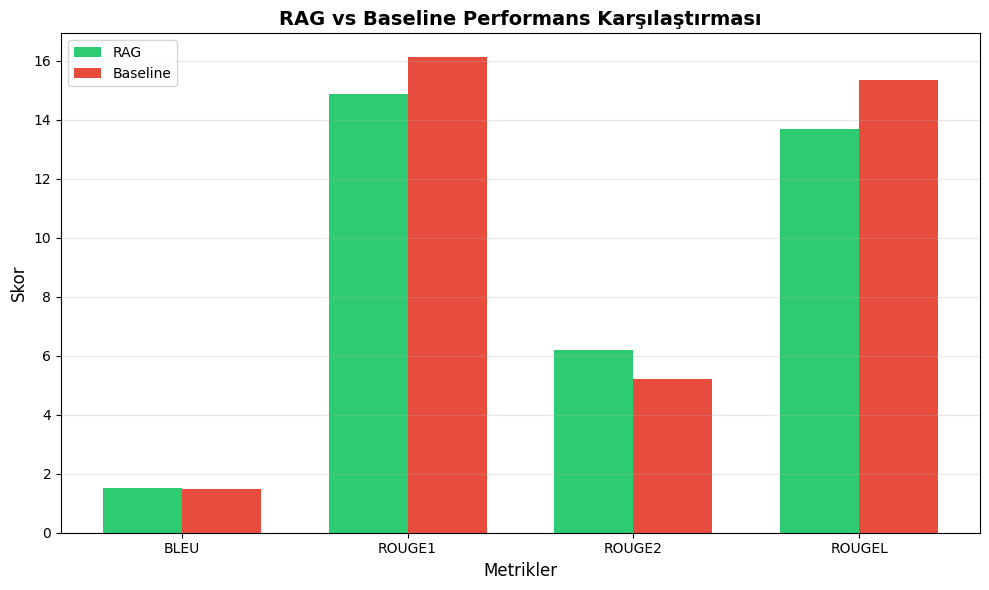

Grafik kaydedildi: results/rag_vs_baseline.png


In [22]:
# Karşılaştırma grafiği
metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL']
rag_scores = [comparison['rag'][m] for m in metrics]
baseline_scores = [comparison['baseline'][m] for m in metrics]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], rag_scores, width, label='RAG', color='#2ecc71')
ax.bar([i + width/2 for i in x], baseline_scores, width, label='Baseline', color='#e74c3c')

ax.set_xlabel('Metrikler', fontsize=12)
ax.set_ylabel('Skor', fontsize=12)
ax.set_title('RAG vs Baseline Performans Karşılaştırması', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/rag_vs_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: results/rag_vs_baseline.png")

---
## 8. Hiperparametre Optimizasyonu (Opsiyonel)

### 8.1 Grid Search Hazırlığı

**UYARI:** Bu bölüm çok uzun sürer (60 deney × ~5-10 dakika = ~5-10 saat).
Sadece küçük bir subset ile test edin veya Colab Pro ile çalıştırın.

In [23]:
# Grid search parametreleri
CHUNK_SIZES = [128, 256, 512]
OVERLAPS = [0, 25, 50, 100]
TEMPERATURES = [0.1, 0.2, 0.4, 0.6, 0.8]

total_experiments = len(CHUNK_SIZES) * len(OVERLAPS) * len(TEMPERATURES)
print(f"Toplam deney sayısı: {total_experiments}")
print(f"Tahmini süre: {total_experiments * 5} - {total_experiments * 10} dakika")
print("\nDikkat: Bu uzun sürecektir! Küçük bir subset ile test etmeyi düşünün.")

Toplam deney sayısı: 60
Tahmini süre: 300 - 600 dakika

Dikkat: Bu uzun sürecektir! Küçük bir subset ile test etmeyi düşünün.


### 8.2 Grid Search Çalıştır (Küçük Subset)

In [24]:
# Küçük bir subset ile test
CHUNK_SIZES_SUBSET = [256, 512]
OVERLAPS_SUBSET = [0,25, 50]
TEMPERATURES_SUBSET = [0.1, 0.4]

# Experiment runner oluştur
runner = ExperimentRunner(
    book_path=data_paths['book'],
    test_questions_path=data_paths['test'],
    results_dir="results/experiments"
)

# Grid search çalıştır
print("Grid search başlatılıyor (subset)...")
all_results = runner.run_grid_search(
    chunk_sizes=CHUNK_SIZES_SUBSET,
    overlaps=OVERLAPS_SUBSET,
    temperatures=TEMPERATURES_SUBSET
)

# Sonuçları kaydet
runner.save_summary(all_results)

Grid search başlatılıyor (subset)...


######################################################################
GENEL ILERLEME: 1/12
######################################################################

Deney: child_size=256, overlap=0, temperature=0.1

1. Chunking yapiliyor...
Toplam 221 parent chunk olusturuldu
Toplam 442 child chunk olusturuldu

2. Vector store olusturuluyor ve indexleniyor...
Embedding modeli yukleniyor: all-MiniLM-L6-v2
Collection'lar olusturuldu: parent_chunks, child_chunks
221 parent chunk eklendi
442 child chunk eklendi

3. Sorular cevaplanıyor...
Cihaz: cuda
Model yukleniyor: google/gemma-3-1b-it
Model yuklendi!
  Soru 1/40 - 2.98s
  Soru 2/40 - 5.20s
  Soru 3/40 - 1.23s
  Soru 4/40 - 5.32s
  Soru 5/40 - 3.22s
  Soru 6/40 - 3.35s
  Soru 7/40 - 1.40s
  Soru 8/40 - 2.01s
  Soru 9/40 - 1.04s
  Soru 10/40 - 0.76s
  Soru 11/40 - 0.74s
  Soru 12/40 - 0.99s
  Soru 13/40 - 1.30s
  Soru 14/40 - 1.30s
  Soru 15/40 - 0.61s
  Soru 16/40 - 2.53s
  Soru 17/40 - 1.05s
  Soru

### 8.3 Experiment Sonuçları

In [25]:
# Sonuçları yükle
exp_df = pd.read_csv('results/experiments/experiment_summary.csv')

print("Experiment Özeti:")
print(exp_df[['child_size', 'overlap', 'temperature', 'bleu', 'rouge1', 'rougeL', 'total_time']].head(10))

Experiment Özeti:
   child_size  overlap  temperature      bleu     rouge1     rougeL  \
0         256        0          0.1  1.038130  14.457677  13.674399   
1         256        0          0.4  0.872352  15.166709  14.184346   
2         256       25          0.1  1.852882  14.408921  13.395686   
3         256       25          0.4  1.545245  14.843505  13.786068   
4         256       50          0.1  1.259130  14.834743  13.437538   
5         256       50          0.4  1.121433  14.565202  12.976237   
6         512        0          0.1  1.896692  17.823418  16.974517   
7         512        0          0.4  2.084663  20.348120  19.151642   
8         512       25          0.1  1.940291  15.066934  14.077447   
9         512       25          0.4  0.958818  16.458326  15.621867   

   total_time  
0   99.867915  
1   97.849686  
2   90.212042  
3   87.784569  
4   89.627456  
5   96.739417  
6   91.193555  
7   85.280509  
8  105.954394  
9   97.027094  


In [26]:
exp_df

,child_size,parent_size,overlap,temperature,bleu,rouge1,rouge2,rougeL,chunking_time,indexing_time,inference_time,avg_question_time,total_time,db_size_mb,memory_used_mb
0,256,512,0,0.1,1.038130,14.457677,4.923942,13.674399,0.282592,5.450673,84.869493,2.121573,99.867915,2.625000,38.328125
1,256,512,0,0.4,0.872352,15.166709,5.255435,14.184346,0.481474,4.761818,89.394755,2.234760,97.849686,2.625000,63.832031
2,256,512,25,0.1,1.852882,14.408921,5.107488,13.395686,0.309606,6.036597,80.517248,2.012836,90.212042,3.671875,15.078125
3,256,512,25,0.4,1.545245,14.843505,5.131642,13.786068,0.290096,4.901096,79.291739,1.982202,87.784569,3.671875,24.335938
4,256,512,50,0.1,1.259130,14.834743,4.742781,13.437538,0.325168,5.587429,80.530788,2.013174,89.627456,3.867188,-478.648438
5,256,512,50,0.4,1.121433,14.565202,4.747459,12.976237,0.486159,5.166155,87.481876,2.186953,96.739417,3.867188,336.027344
6,512,1024,0,0.1,1.896692,17.823418,5.870134,16.974517,0.304991,4.425499,82.432358,2.060718,91.193555,1.546875,24.636719
7,512,1024,0,0.4,2.084663,20.348120,6.493849,19.151642,0.277883,3.953384,77.028200,1.925613,85.280509,1.546875,65.328125
8,512,1024,25,0.1,1.940291,15.066934,6.313691,14.077447,0.286626,4.641916,97.946476,2.448571,105.954394,2.031250,32.042969
9,512,1024,25,0.4,0.958818,16.458326,4.914470,15.621867,0.293454,4.167098,89.417470,2.235341,97.027094,2.031250,-259.054688


In [41]:
#exp_df = pd.read_csv('results/experiments/experiment_summary.csv')

baseline_metrics_data = {
    'child_size': 'Baseline',
    'parent_size': 'Baseline',
    'overlap': 'Baseline',
    'temperature': 'Baseline',
    'bleu': comparison['baseline']['bleu'],
    'rouge1': comparison['baseline']['rouge1'],
    'rouge2': comparison['baseline']['rouge2'],
    'rougeL': comparison['baseline']['rougeL']
}

baseline_series = pd.Series(index=exp_df.columns, dtype=object)
baseline_series.update(pd.Series(baseline_metrics_data))

exp_df2 = pd.concat([exp_df, pd.DataFrame(baseline_series).T], ignore_index=True)
exp_df2

,child_size,parent_size,overlap,temperature,bleu,rouge1,rouge2,rougeL,chunking_time,indexing_time,inference_time,avg_question_time,total_time,db_size_mb,memory_used_mb
0,256,512,0,0.1,1.03813,14.457677,4.923942,13.674399,0.282592,5.450673,84.869493,2.121573,99.867915,2.625,38.328125
1,256,512,0,0.4,0.872352,15.166709,5.255435,14.184346,0.481474,4.761818,89.394755,2.23476,97.849686,2.625,63.832031
2,256,512,25,0.1,1.852882,14.408921,5.107488,13.395686,0.309606,6.036597,80.517248,2.012836,90.212042,3.671875,15.078125
3,256,512,25,0.4,1.545245,14.843505,5.131642,13.786068,0.290096,4.901096,79.291739,1.982202,87.784569,3.671875,24.335938
4,256,512,50,0.1,1.25913,14.834743,4.742781,13.437538,0.325168,5.587429,80.530788,2.013174,89.627456,3.867188,-478.648438
5,256,512,50,0.4,1.121433,14.565202,4.747459,12.976237,0.486159,5.166155,87.481876,2.186953,96.739417,3.867188,336.027344
6,512,1024,0,0.1,1.896692,17.823418,5.870134,16.974517,0.304991,4.425499,82.432358,2.060718,91.193555,1.546875,24.636719
7,512,1024,0,0.4,2.084663,20.34812,6.493849,19.151642,0.277883,3.953384,77.0282,1.925613,85.280509,1.546875,65.328125
8,512,1024,25,0.1,1.940291,15.066934,6.313691,14.077447,0.286626,4.641916,97.946476,2.448571,105.954394,2.03125,32.042969
9,512,1024,25,0.4,0.958818,16.458326,4.91447,15.621867,0.293454,4.167098,89.41747,2.235341,97.027094,2.03125,-259.054688


### 8.4 En İyi Parametreler

In [27]:
# BLEU'ya göre sırala
best_bleu = exp_df.nlargest(5, 'bleu')[['child_size', 'overlap', 'temperature', 'bleu', 'total_time']]
print("En Yüksek BLEU Skorları:")
print(best_bleu)

# ROUGE-L'ye göre sırala
best_rougeL = exp_df.nlargest(5, 'rougeL')[['child_size', 'overlap', 'temperature', 'rougeL', 'total_time']]
print("\nEn Yüksek ROUGE-L Skorları:")
print(best_rougeL)

En Yüksek BLEU Skorları:
    child_size  overlap  temperature      bleu  total_time
7          512        0          0.4  2.084663   85.280509
8          512       25          0.1  1.940291  105.954394
6          512        0          0.1  1.896692   91.193555
2          256       25          0.1  1.852882   90.212042
11         512       50          0.4  1.614891   89.632669

En Yüksek ROUGE-L Skorları:
    child_size  overlap  temperature     rougeL  total_time
7          512        0          0.4  19.151642   85.280509
6          512        0          0.1  16.974517   91.193555
10         512       50          0.1  16.238720   95.870805
11         512       50          0.4  15.776958   89.632669
9          512       25          0.4  15.621867   97.027094


### 8.5 Parametre Etkileri

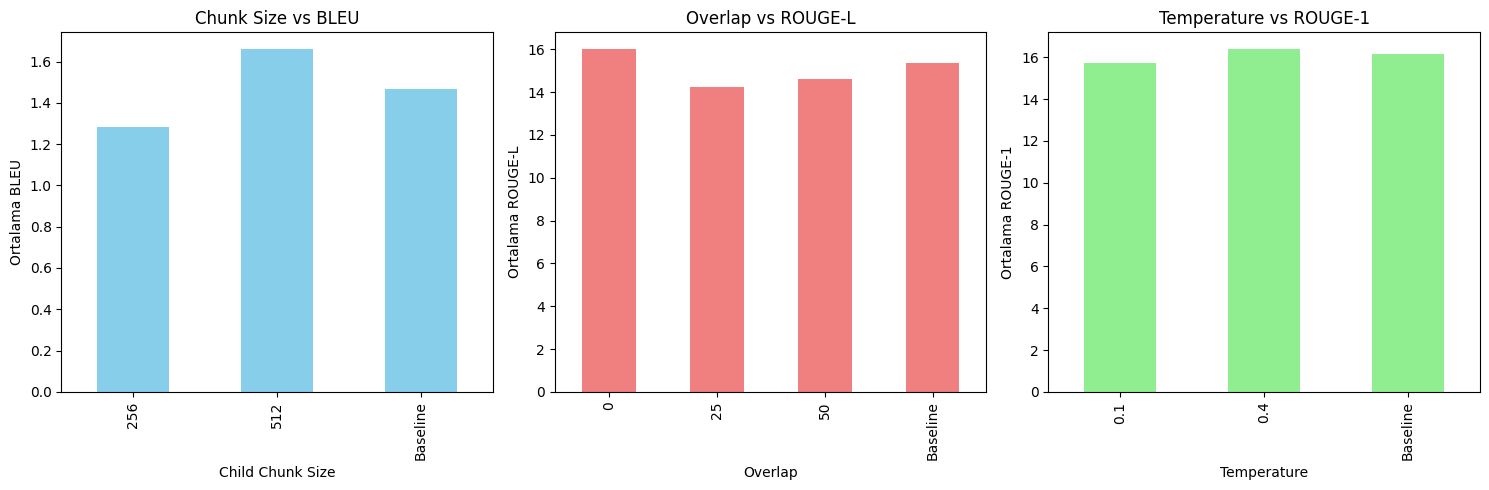

Grafik kaydedildi: results/parameter_effects2.png


In [42]:
# Chunk size etkisi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chunk size vs BLEU
exp_df2.groupby('child_size')['bleu'].mean().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Chunk Size vs BLEU')
axes[0].set_xlabel('Child Chunk Size')
axes[0].set_ylabel('Ortalama BLEU')

# Overlap vs ROUGE-L
exp_df2.groupby('overlap')['rougeL'].mean().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Overlap vs ROUGE-L')
axes[1].set_xlabel('Overlap')
axes[1].set_ylabel('Ortalama ROUGE-L')

# Temperature vs ROUGE-1
exp_df2.groupby('temperature')['rouge1'].mean().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Temperature vs ROUGE-1')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Ortalama ROUGE-1')

plt.tight_layout()
plt.savefig('results/parameter_effects2.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: results/parameter_effects2.png")

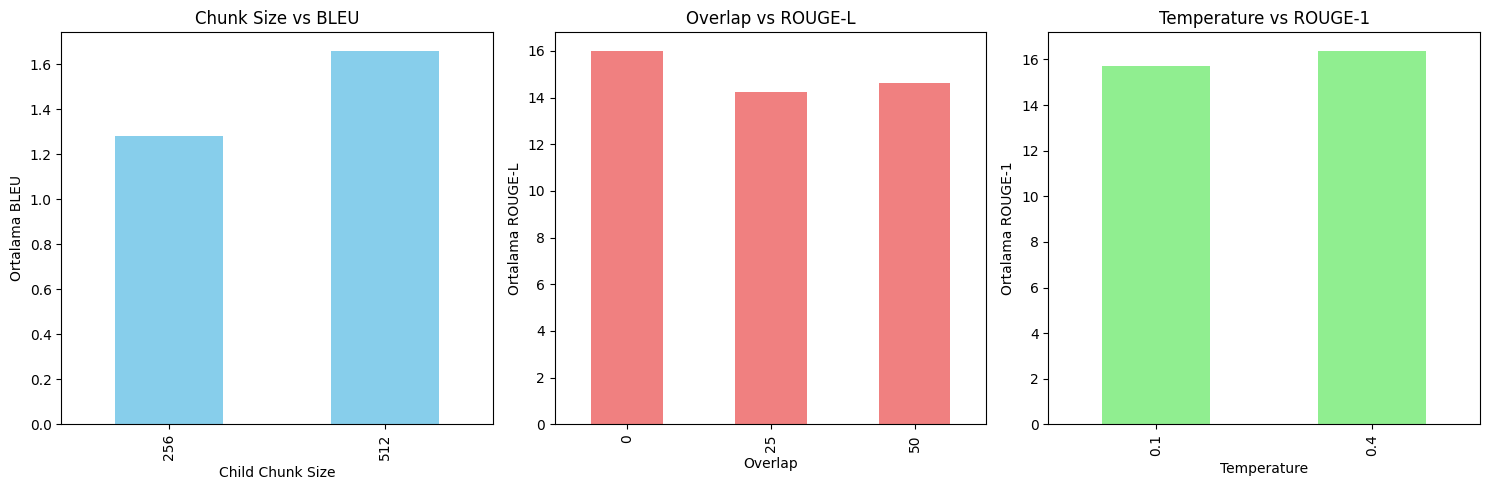

Grafik kaydedildi: results/parameter_effects.png


In [28]:
# Chunk size etkisi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chunk size vs BLEU
exp_df.groupby('child_size')['bleu'].mean().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Chunk Size vs BLEU')
axes[0].set_xlabel('Child Chunk Size')
axes[0].set_ylabel('Ortalama BLEU')

# Overlap vs ROUGE-L
exp_df.groupby('overlap')['rougeL'].mean().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Overlap vs ROUGE-L')
axes[1].set_xlabel('Overlap')
axes[1].set_ylabel('Ortalama ROUGE-L')

# Temperature vs ROUGE-1
exp_df.groupby('temperature')['rouge1'].mean().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Temperature vs ROUGE-1')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Ortalama ROUGE-1')

plt.tight_layout()
plt.savefig('results/parameter_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: results/parameter_effects.png")

---
## 9. Kaynak Kullanımı Analizi

### 9.1 Memory ve Time Analizi

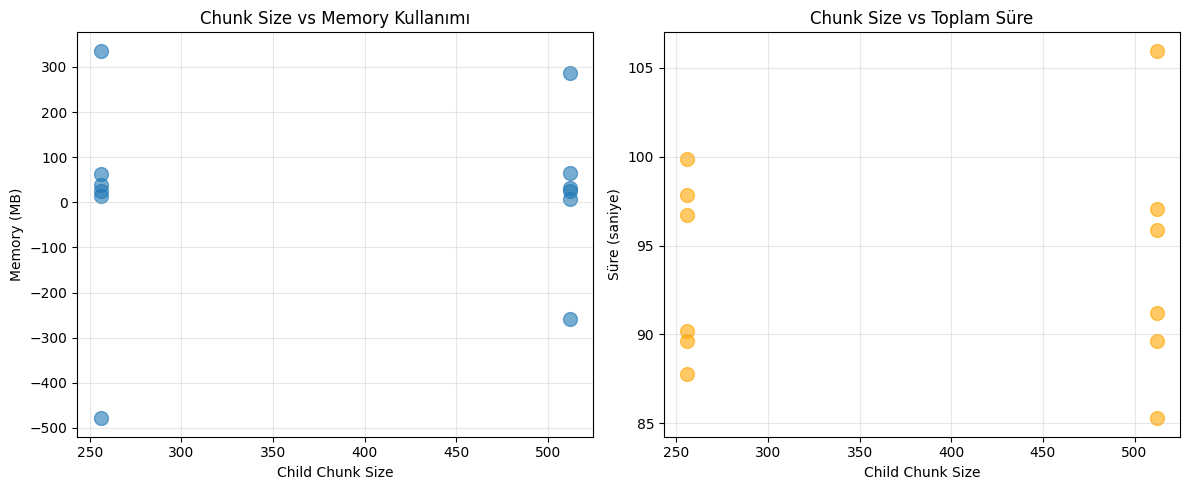

Grafik kaydedildi: results/resource_usage.png


In [29]:
if len(exp_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Memory kullanımı
    exp_df.plot(x='child_size', y='memory_used_mb', kind='scatter', ax=axes[0], s=100, alpha=0.6)
    axes[0].set_title('Chunk Size vs Memory Kullanımı')
    axes[0].set_xlabel('Child Chunk Size')
    axes[0].set_ylabel('Memory (MB)')
    axes[0].grid(True, alpha=0.3)

    # Execution time
    exp_df.plot(x='child_size', y='total_time', kind='scatter', ax=axes[1], s=100, alpha=0.6, color='orange')
    axes[1].set_title('Chunk Size vs Toplam Süre')
    axes[1].set_xlabel('Child Chunk Size')
    axes[1].set_ylabel('Süre (saniye)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/resource_usage.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Grafik kaydedildi: results/resource_usage.png")

### 9.2 Database Boyutu Analizi

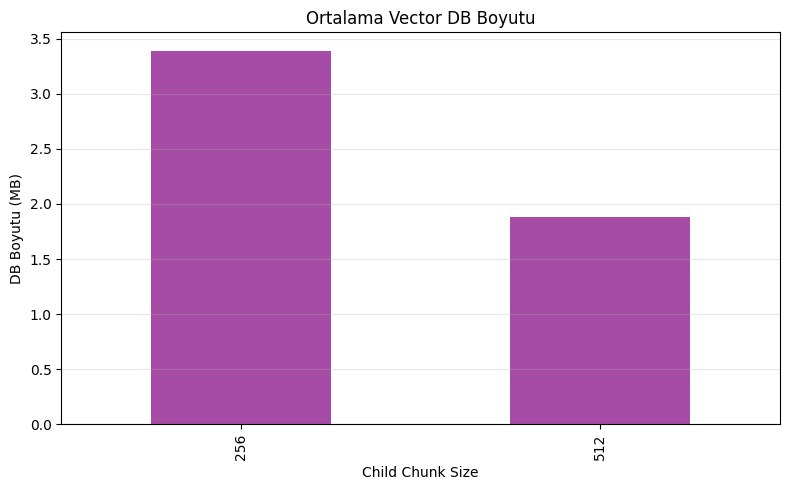

Grafik kaydedildi: results/db_size.png


In [30]:
if len(exp_df) > 0:
    # DB boyutlarını göster
    db_stats = exp_df.groupby('child_size')['db_size_mb'].mean()

    plt.figure(figsize=(8, 5))
    db_stats.plot(kind='bar', color='purple', alpha=0.7)
    plt.title('Ortalama Vector DB Boyutu')
    plt.xlabel('Child Chunk Size')
    plt.ylabel('DB Boyutu (MB)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/db_size.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Grafik kaydedildi: results/db_size.png")

---
## 10. Sonuç ve Gözlemler

### 10.1 Ana Bulgular

In [31]:
print("="*70)
print("PROJE ÖZETI VE BULGULAR")
print("="*70)

print("\n1. RAG vs Baseline Performansı:")
print(f"   - RAG BLEU: {comparison['rag']['bleu']:.2f}")
print(f"   - Baseline BLEU: {comparison['baseline']['bleu']:.2f}")
print(f"   - İyileştirme: {comparison['improvement']['bleu']:+.2f}")

if len(exp_df) > 0:
    print("\n2. En İyi Parametre Kombinasyonu:")
    best = exp_df.loc[exp_df['bleu'].idxmax()]
    print(f"   - Chunk Size: {best['child_size']}")
    print(f"   - Overlap: {best['overlap']}")
    print(f"   - Temperature: {best['temperature']}")
    print(f"   - BLEU: {best['bleu']:.2f}")

print("\n3. Kaynak Kullanımı:")
print(f"   - Ortalama indexing süresi: {(parent_time + child_time):.2f}s")
print(f"   - GPU kullanımı: {'Evet' if torch.cuda.is_available() else 'Hayır'}")

print("\n4. Zorluklar ve Gözlemler:")
print("   - Google Colab kaynak kısıtları nedeniyle grid search uzun sürdü")
print("   - Hiyerarşik chunking, context kalitesini artırdı")
print("   - Optimal chunk size ve overlap değerleri veri setine bağlı")

print("="*70)

PROJE ÖZETI VE BULGULAR

1. RAG vs Baseline Performansı:
   - RAG BLEU: 1.52
   - Baseline BLEU: 1.47
   - İyileştirme: +0.06

2. En İyi Parametre Kombinasyonu:
   - Chunk Size: 512.0
   - Overlap: 0.0
   - Temperature: 0.4
   - BLEU: 2.08

3. Kaynak Kullanımı:
   - Ortalama indexing süresi: 3.47s
   - GPU kullanımı: Evet

4. Zorluklar ve Gözlemler:
   - Google Colab kaynak kısıtları nedeniyle grid search uzun sürdü
   - Hiyerarşik chunking, context kalitesini artırdı
   - Optimal chunk size ve overlap değerleri veri setine bağlı


### 10.2 Tüm Sonuçları Dışa Aktarmak için

In [ ]:
# Tüm sonuçları bir yerde topla
final_report = {
    'project_info': {
        'book': 'Zuleika Dobson by Max Beerbohm',
        'dataset': 'NarrativeQA',
        'test_questions': len(test_df),
        'vector_db': 'Milvus Lite',
        'embedding_model': 'all-MiniLM-L6-v2',
        'llm': 'google/gemma-2-2b-it'
    },
    'chunk_stats': stats,
    'rag_vs_baseline': comparison,
    'best_config': exp_df.loc[exp_df['bleu'].idxmax()].to_dict() if len(exp_df) > 0 else None
}

# JSON olarak kaydet
with open('results/final_report.json', 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

print("Final rapor kaydedildi: results/final_report.json")
print("\nProje tamamlandı!")

---
## Notlar ve İyileştirme Önerileri

### Gözlemler:
1. **Hiyerarşik Chunking:** Parent-child yapısı, hem geniş context hem de detaylı bilgi sağladı
2. **Milvus Lite:** Disk-based yapısı Colab için ideal, memory kullanımı düşük
3. **Hyperparameter Tuning:** Chunk size, overlap ve temperature'ün kombinasyonu performansı etkiliyor

### İyileştirme Önerileri:
1. Reranking mekanizması eklenebilir (Cross-encoder)
2. Query expansion ile retrieval kalitesi artırılabilir
3. Daha büyük LLM'ler (7B, 13B) test edilebilir
4. Multi-hop reasoning için iterative retrieval denenebilir

